# Build a simple image classifier from a standard dataset
Adapted from https://www.tensorflow.org/tutorials/images/cnn

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

Note: The following cell will give you an error like "No module named 'matplotlib'" if you have not yet installed matplotlib. To install it, open up a terminal/command window, activate your environment (e.g., `conda activate coding3`), and then type `conda install matplotlib`

You may have to restart the kernel if the cell does not complete running after you install.

Note that you will only ever have to do this once per environment (e.g., from now on, when you run a new notebook that imports from matplotlib using this same environment, it will also be able to use that library; no need to install again)

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers.legacy import Adam
# from utils import generate_ds

import numpy as np

from PIL import Image

root_path = "micro/"

In [3]:
def read_resize_image(path):
    # read image from path and resize the image to 255*255, return as numpy array
    img = Image.open(path)
    img = img.resize((256, 256))
    img_array = np.array(img).tolist()
    return img_array

In [4]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    brightness_range=[0.3,0.8],
    validation_split=0.1
)

# Load Data
train_ds = gen.flow_from_directory(
    root_path,
    batch_size=64, # For better utilization of GPU, I have kept the batch size a little bit
    shuffle=True,
    class_mode='binary',
    target_size=(256,256), # This image size is generally sufficient for better image classifications.
    subset='training'
)

test_ds = gen.flow_from_directory(
    root_path,
    batch_size=64, # For faster inference, the batch size here is small.
    shuffle=True,
    class_mode='binary',
    target_size=(256,256), # This image size is generally sufficient for better image classifications.
    subset='validation'
)

x_train, y_train = train_ds.next()
x_test, y_test = test_ds.next()

Found 714 images belonging to 8 classes.
Found 75 images belonging to 8 classes.


In [5]:
x_train

array([[[[0.09803922, 0.53333336, 0.03921569],
         [0.09803922, 0.53333336, 0.03921569],
         [0.09803922, 0.53333336, 0.03921569],
         ...,
         [0.09803922, 0.53333336, 0.03921569],
         [0.09803922, 0.53333336, 0.03921569],
         [0.09803922, 0.53333336, 0.03921569]],

        [[0.09803922, 0.53333336, 0.03921569],
         [0.09803922, 0.53333336, 0.03921569],
         [0.09803922, 0.53333336, 0.03921569],
         ...,
         [0.09803922, 0.53333336, 0.03921569],
         [0.09803922, 0.53333336, 0.03921569],
         [0.09803922, 0.53333336, 0.03921569]],

        [[0.09803922, 0.53333336, 0.03921569],
         [0.09803922, 0.53333336, 0.03921569],
         [0.09803922, 0.53333336, 0.03921569],
         ...,
         [0.09803922, 0.53333336, 0.03921569],
         [0.09803922, 0.53333336, 0.03921569],
         [0.09803922, 0.53333336, 0.03921569]],

        ...,

        [[0.09803922, 0.53333336, 0.03921569],
         [0.09803922, 0.53333336, 0.03921569]

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [11]:
def show_images(data, GRID=[2,6], model=None, size=(25,10)):

    # The plotting configurations
    n_rows, n_cols = GRID
    n_images = n_rows * n_cols
    plt.figure(figsize=size)

    # Data for visualization
    images, labels = next(iter(data)) # This process can take a little time because of the large batch size

    # Iterate through the subplots.
    for i in range(1, n_images+1):

        # Select a random data
        id = np.random.randint(len(images)) # This is a dynamic function because for validation data and training data, the length of total images is different.
        image, label = images[id], class_names[int(labels[id])]

        # Plot the sub plot
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.axis('off')

        # If model is available make predictions.
        if model is not None:
            pred = class_names[np.argmax(model.predict(image[np.newaxis,...]))]
            title = f"Class : {label}\nPred : {pred}"
        else:
            title = f"Class : {label}"

        plt.title(title)
    plt.show()

In [ ]:
class_names = ['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']
show_images(data=train_ds)

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


### Create the neural network

We're going to skip over the details for now of how this works. We'll talk about this in lecture next week. If you want more information now, though, feel free to refer to the [Original tutorial](https://www.tensorflow.org/tutorials/images/cnn). 

For now, trust that the code below makes a new neural network in keras. Each `.add()` function call either adds a new layer of neurons of a particular type, or specifies some processing that will be applied to the neurons in the layer that was just added.

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

### Compile and train the model

The `compile` function specifies which optimisation algorithm to use when training the network. Here, we are using the "adam" optimizer and we are telling it to minimise a particular type of error (loss) called "sparse categorical cross-entropy" (more on these later; don't worry for now). The `metrics=['accuracy']` bit tells it to print out the model accuracy on the training and test datasets after every epoch (training pass). Validation set should generally improve as you train for more epochs, though sometimes the model begins to *overfit* and you will see validation set accuracy decrease even if training set accuracy continues to be good.

The `fit` function actually does the model training. The code below specifies that 10 training epochs should be performed. Note that we pass the "validation data" (i.e., our hold-out set) to the `fit` function only for the purposes of computing the accuracy on this dataset after each epoch, which we'll examine later, below.

In [16]:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=50,
                    validation_data=test_ds)

Epoch 1/50
78/78 [==============================] - 60s 755ms/step - loss: 1.4164 - accuracy: 0.3569 - val_loss: 1.3747 - val_accuracy: 0.3126
Epoch 2/50
78/78 [==============================] - 58s 745ms/step - loss: 1.2374 - accuracy: 0.4449 - val_loss: 1.3631 - val_accuracy: 0.2907
Epoch 3/50
78/78 [==============================] - 59s 748ms/step - loss: 1.1383 - accuracy: 0.5131 - val_loss: 1.2856 - val_accuracy: 0.3766
Epoch 4/50
78/78 [==============================] - 59s 748ms/step - loss: 1.0302 - accuracy: 0.5727 - val_loss: 1.3362 - val_accuracy: 0.3711
Epoch 5/50
78/78 [==============================] - 58s 747ms/step - loss: 0.9167 - accuracy: 0.6388 - val_loss: 1.2636 - val_accuracy: 0.4424
Epoch 6/50
78/78 [==============================] - 59s 755ms/step - loss: 0.7709 - accuracy: 0.7033 - val_loss: 1.2780 - val_accuracy: 0.4717
Epoch 7/50
78/78 [==============================] - 58s 737ms/step - loss: 0.6871 - accuracy: 0.7329 - val_loss: 1.2351 - val_accuracy: 0.5210

### Plot how accuracy changes over time on the training set and the test ("validation") set

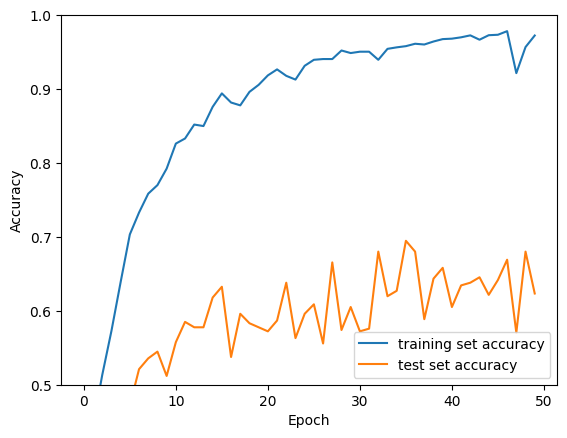

In [17]:
plt.plot(history.history['accuracy'], label='training set accuracy')
plt.plot(history.history['val_accuracy'], label = 'test set accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [56]:
#You can use code like this to test a trained model on any other dataset
# Here we're using test_images and test_labels again, but you could imagine replacing this with totally different data
test_loss, test_acc = model.evaluate(test_ds[0],  test_ds[1], verbose=2)
print("Test accuracy after final epoch is ", test_acc*100)

ValueError: in user code:

    File "/Users/pannic/miniforge3/envs/CC-Coding-Three/lib/python3.10/site-packages/keras/engine/training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "/Users/pannic/miniforge3/envs/CC-Coding-Three/lib/python3.10/site-packages/keras/engine/training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/pannic/miniforge3/envs/CC-Coding-Three/lib/python3.10/site-packages/keras/engine/training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "/Users/pannic/miniforge3/envs/CC-Coding-Three/lib/python3.10/site-packages/keras/engine/training.py", line 1788, in test_step
        y_pred = self(x, training=False)
    File "/Users/pannic/miniforge3/envs/CC-Coding-Three/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/pannic/miniforge3/envs/CC-Coding-Three/lib/python3.10/site-packages/keras/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "sequential_4" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(32, 256, 256, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(32,) dtype=float32>]


In [59]:
?models.Sequential()

Object `models.Sequential()` not found.
